# 03 – Baseline Modeling (Linear & Logistic Regression)

Goal of this notebook:

- Build simple baseline models on engineered features:
  - Linear Regression for RUL.
  - Logistic Regression for "failure within horizon".
- Inspect their performance and limitations.


In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    ConfusionMatrixDisplay,
)
from sklearn.preprocessing import StandardScaler

# --- Paths / environment ---
project_root = Path.cwd().parent       # notebooks/ → project root
sys.path.append(str(project_root))
print("Project root:", project_root)

from src.utils import time_based_unit_split
from src.make_features import add_classification_label

plt.style.use("seaborn-v0_8")
sns.set(font_scale=1.1)

features_path = project_root / "data" / "processed" / "features_fd001.csv"
features_path


Project root: /Users/arnavthakur/Documents/Data Science Projects/Industrial_Equipment_Failure_Prediction


PosixPath('/Users/arnavthakur/Documents/Data Science Projects/Industrial_Equipment_Failure_Prediction/data/processed/features_fd001.csv')

In [2]:
df = pd.read_csv(features_path)
df = add_classification_label(df, horizon=30, label_col="fail_within_horizon")

df.head()


,unit,cycle,RUL,setting_1_last,setting_2_last,setting_3_last,s_2_mean,s_2_std,s_2_min,s_2_max,...,s_21_mean,s_21_std,s_21_min,s_21_max,s_21_slope,s_21_fft_power,s_21_fft_top1,s_21_fft_top2,s_21_fft_top3,fail_within_horizon
0,1,30,162.0,-0.0022,0.0000,100.0,642.328333,0.328498,641.71,643.07,...,23.385460,0.052695,23.2757,23.4787,-0.000114,1.212065,0.512046,0.473638,0.446132,0
1,1,31,161.0,0.0014,0.0005,100.0,642.335000,0.319739,641.71,643.07,...,23.382670,0.053073,23.2757,23.4787,-0.000207,1.240565,0.521345,0.441108,0.439178,0
2,1,32,160.0,0.0005,-0.0003,100.0,642.341000,0.317830,641.71,643.07,...,23.385213,0.056799,23.2757,23.4999,0.000832,1.434924,0.597645,0.510473,0.425327,0
3,1,33,159.0,-0.0042,-0.0004,100.0,642.353000,0.324899,641.71,643.07,...,23.385427,0.056652,23.2757,23.4999,0.000326,1.426056,0.591807,0.516095,0.419047,0
4,1,34,158.0,0.0015,-0.0001,100.0,642.359333,0.326686,641.71,643.07,...,23.383270,0.058313,23.2757,23.4999,-0.000245,1.495382,0.550902,0.504783,0.454155,0


In [3]:
df_train, df_val, df_test = time_based_unit_split(df)

len(df_train), len(df_val), len(df_test)


Total units: 100
Train units: 60, Val units: 20, Test units: 20


(10202, 3616, 3913)

In [4]:
TARGET_RUL_COL = "RUL"
CLASS_LABEL_COL = "fail_within_horizon"

blacklist = {"unit", "cycle", TARGET_RUL_COL, CLASS_LABEL_COL}
feature_cols = [c for c in df.columns if c not in blacklist]

len(feature_cols), feature_cols[:5]


(138,
 ['setting_1_last', 'setting_2_last', 'setting_3_last', 's_2_mean', 's_2_std'])

In [5]:
X_train = df_train[feature_cols].values
y_train = df_train[TARGET_RUL_COL].values
X_val = df_val[feature_cols].values
y_val = df_val[TARGET_RUL_COL].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

y_pred_val = lin_reg.predict(X_val_scaled)
mae = mean_absolute_error(y_val, y_pred_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))

mae, rmse


(29.337968706358172, np.float64(43.57409377779445))

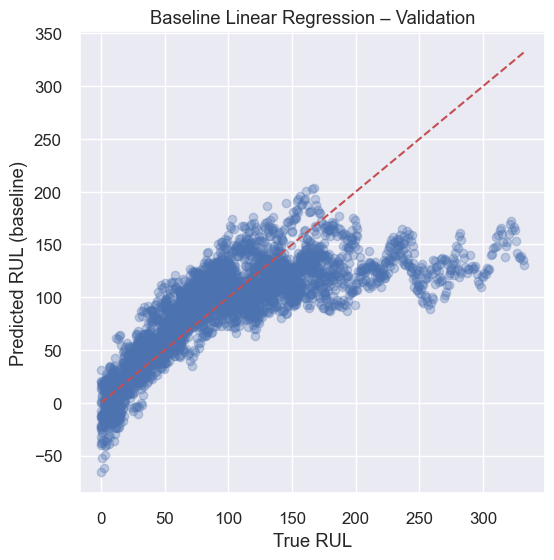

In [6]:
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred_val, alpha=0.3)
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL (baseline)")
plt.title("Baseline Linear Regression – Validation")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], "r--")
plt.show()


In [7]:
X_train_cls = X_train
X_val_cls = X_val
y_train_cls = df_train[CLASS_LABEL_COL].values
y_val_cls = df_val[CLASS_LABEL_COL].values

log_reg = LogisticRegression(max_iter=1000, class_weight="balanced")
log_reg.fit(X_train_cls, y_train_cls)

y_pred_cls = log_reg.predict(X_val_cls)
y_prob_cls = log_reg.predict_proba(X_val_cls)[:, 1]

acc = accuracy_score(y_val_cls, y_pred_cls)
prec = precision_score(y_val_cls, y_pred_cls)
rec = recall_score(y_val_cls, y_pred_cls)
f1 = f1_score(y_val_cls, y_pred_cls)
roc = roc_auc_score(y_val_cls, y_prob_cls)

{"acc": acc, "prec": prec, "rec": rec, "f1": f1, "roc_auc": roc}


/Users/arnavthakur/Documents/Data Science Projects/Industrial_Equipment_Failure_Prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'acc': 0.9175884955752213,
 'prec': 0.6817155756207675,
 'rec': 0.9741935483870968,
 'f1': 0.8021248339973439,
 'roc_auc': 0.9889632413109952}

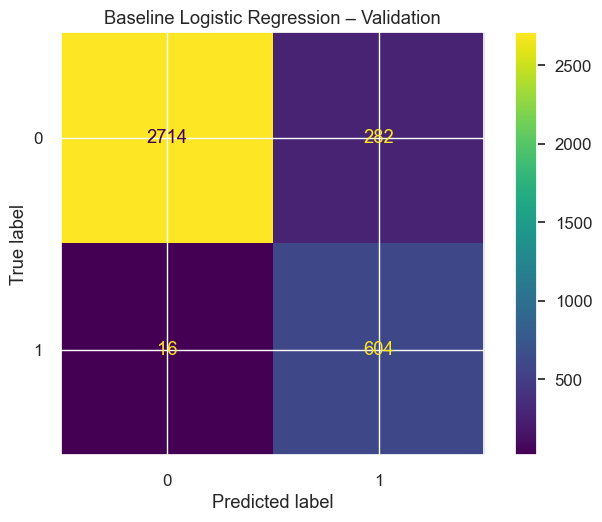

In [8]:
ConfusionMatrixDisplay.from_predictions(y_val_cls, y_pred_cls)
plt.title("Baseline Logistic Regression – Validation")
plt.show()
